In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_WS = pd.read_csv('glm_generation_Austin/Ercot_LZ_SOUTH.csv',parse_dates=True,index_col=[0]) # For year 2016
df_WS.head()

,DA,RT
2016-01-01 00:00:00,18.22,15.48
2016-01-01 00:05:00,18.22,15.48
2016-01-01 00:10:00,18.22,15.48
2016-01-01 00:15:00,18.22,15.33
2016-01-01 00:20:00,18.22,15.33


In [3]:
start = datetime.datetime( 2016, 7, 1)
end = datetime.datetime( 2016, 7, 7, 1, 0)
interval = 300 # interval of market operation
market_intervals = pd.date_range(start,end,freq=str(int(interval/60))+'min')
market_intervals #the first hour in 5 minute increments
index = len(market_intervals)
print(len(market_intervals))

1741


In [4]:
RT = df_WS['RT']
prices = df_WS.RT[0:index]
print(prices)
#print(len(prices))

2016-01-01 00:00:00    15.48
2016-01-01 00:05:00    15.48
2016-01-01 00:10:00    15.48
2016-01-01 00:15:00    15.33
2016-01-01 00:20:00    15.33
                       ...  
2016-01-06 22:15:00    19.68
2016-01-06 22:20:00    19.68
2016-01-06 22:25:00    19.68
2016-01-06 22:30:00    19.13
2016-01-06 22:35:00    19.13
Name: RT, Length: 1741, dtype: float64


In [5]:
# Initialize price parameters
#prices = list(range(10,22))
T = len(prices)

# Initialize variables
SOC = cp.Variable((T+1,))
x = cp.Variable((T,))

# Initialize constraints
constraints = [(SOC[0]==2), (SOC[T]==2)]
for t in range(T):
    constraints += [(-1<=x[t]), (x[t]<=1), 1<=SOC[t], SOC[t]<=5, SOC[t+1]==0.9999*SOC[t]+x[t]/12.]

# Objective function
#obj = cp.sum(prices*x)
obj = cp.sum(cp.multiply(prices,x))
obj = cp.Maximize(obj)

In [6]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = prob.solve() #returns optimal value = prob.value
print(profits)

3569.6492221947087


In [7]:
SOC_values = SOC.value

In [8]:
# Print output and solution characteristics

print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)
print(x)

# is it ok that the x array contains values other than -1, 0, 1?

status: optimal
optimal value 3569.6492221947087
optimal var [ 1.  1.  1. ... -1. -1. -1.]
var1


In [9]:
x_values = x.value
print(x_values)

[ 1.  1.  1. ... -1. -1. -1.]


In [10]:
Pd = 0
Qd = x_values[0]
SOC = 2
df_store = pd.DataFrame(columns=['timestamp', 'RT', 'SOC_t', 'dispatch'])

In [11]:
df_store

,timestamp,RT,SOC_t,dispatch


In [12]:
len(x_values)

1741

In [13]:
(x_values)

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [14]:

first_element=[0]
SOC_values_final = np.delete(SOC_values, first_element)
SOC_values_final.size


1741

In [15]:
df_WS = df_WS[~df_WS.index.duplicated(keep='last')]
df_WS_restricted = df_WS.loc[market_intervals]

In [16]:
df_store['timestamp'] = df_WS_restricted.index
df_store['RT'] = df_store.timestamp.map(df_WS_restricted['RT'].to_dict())
df_store['SOC_t'] = SOC_values_final
df_store['dispatch'] = x_values

# df_store.loc[df_store.duplicated(subset='timestamp')]

#df_store.drop_duplicates(subset='timestamp', keep='last', inplace=True)
#get df_store to be same size as x_values and SOC_values
#directly write this array to dataframe column
df_store

,timestamp,RT,SOC_t,dispatch
0,2016-07-01 00:00:00,19.48,2.083133,1.0
1,2016-07-01 00:05:00,19.48,2.166258,1.0
2,2016-07-01 00:10:00,19.48,2.249375,1.0
3,2016-07-01 00:15:00,19.92,2.332483,1.0
4,2016-07-01 00:20:00,19.92,2.415584,1.0
...,...,...,...,...
1736,2016-07-07 00:40:00,18.14,2.334217,-1.0
1737,2016-07-07 00:45:00,17.73,2.250650,-1.0
1738,2016-07-07 00:50:00,17.73,2.167092,-1.0
1739,2016-07-07 00:55:00,17.73,2.083542,-1.0


In [17]:
def visualize_battery_dispatch(data):
    # Visualize battery dispatch over time as well as the market price
    fig = plt.figure(figsize=(9,3),dpi=150) 
    ax = fig.add_subplot(111)
    
    plot1 = ax.plot(data.timestamp, data.RT, color='xkcd:sky blue', label='RT')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/MWh)')
    ax.set_xlim(xmin=data.iloc[0]['timestamp'], xmax=data.iloc[-1]['timestamp']+pd.Timedelta(days=1))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_ylim(0.0,150)

    ax2 = ax.twinx()
    plot2 = ax2.plot(data.timestamp, data.SOC_t, color='orange', label='SOC')
    ax2.set_ylabel('State of Charge')
    ax2.set_ylim(-4,10)
    
    
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    plot3 = ax3.plot(data.timestamp, data.dispatch, color='red', label='load')
    ax3.set_ylabel('Load Dispatched')
    ax3.set_ylim(-8,2)


    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

<ipython-input-17-f8e1f1707c00>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


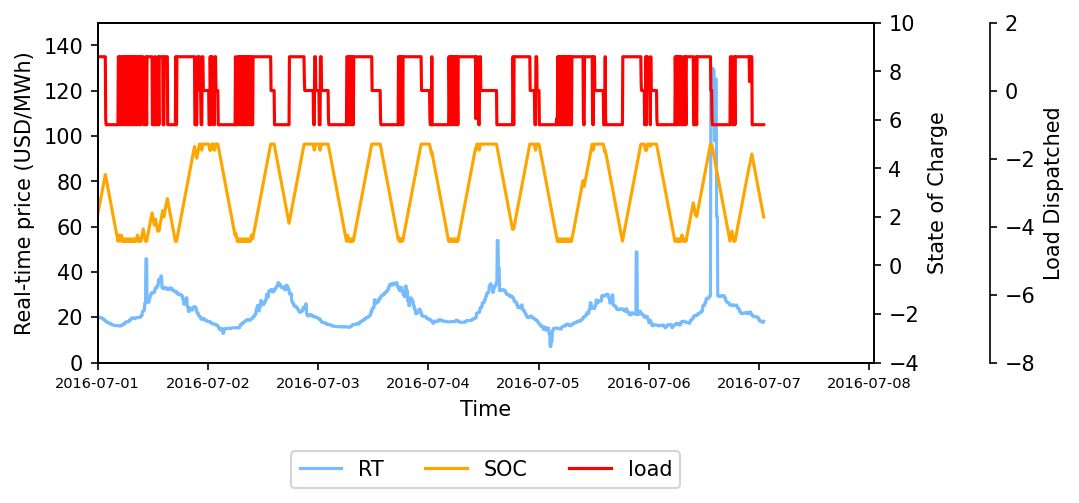

In [18]:
visualize_battery_dispatch(df_store)